# Coursework 3 - Mathematical Methods for Neural Science and Engineering

- Name : Diane d'Haultfoeuille
- Date : 15.01.2024

# Load the calcium imaging dataset

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Math Methods Coursework 3
@author: Diane d'Haultfoeuille
"""

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# %% Load dataset

datadir = 'data/dataset3_m62/'
trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']; x = trackdata['x']; y = trackdata['y']; r=trackdata['r'];
speed = trackdata['speed']; t = trackdata['time'];
spikedata = io.loadmat(datadir+'spikes.mat')
spikes = spikedata['spikes']
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')
dFonF = fluodata['ddf_f'] # fluorescence time-series variable
C = np.size(dFonF,0) # number of cells
fs = 30.92 # sampling rate in Hz - everything is resampled at this rate
L = np.size(dFonF,1)
t = np.linspace(0,L*1/fs,L) # duration of recording in sec

# Question 1 : Spike train

To convert the fluorescent time series of each cell, I used a simple threshold-crossing method, in which an event is detected if the amplitude of a spike is above the threshold value. The value 1 represents an even detection, 0 no events. The threshold value is set at the mean of the spike amplitude values + one standard deviation. Also, the avoid taking into account the slow decay of a spike, I set a boolean value "current_peak". It takes the value "True" when a spike is detected (binary response changes from 0 to 1), and retake the value "False" only when the spike amplitude reaches a value under the threshold. So the binary response (or event_train) takes the value 1 only if the spike amplitude is above the threshold AND the boolean value is "False".

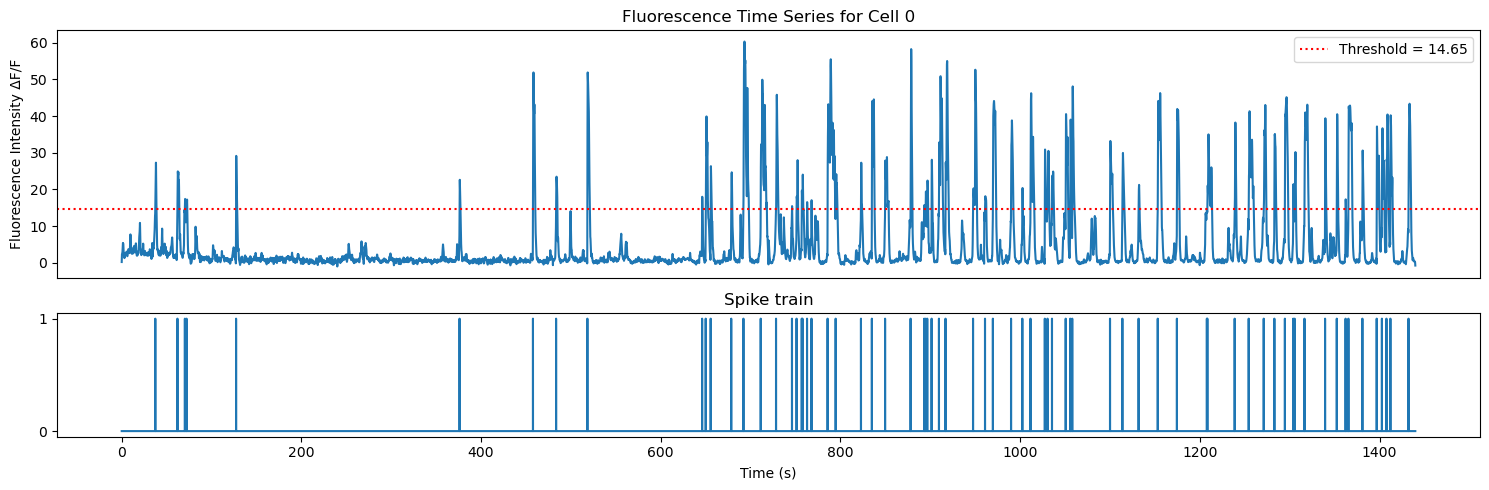

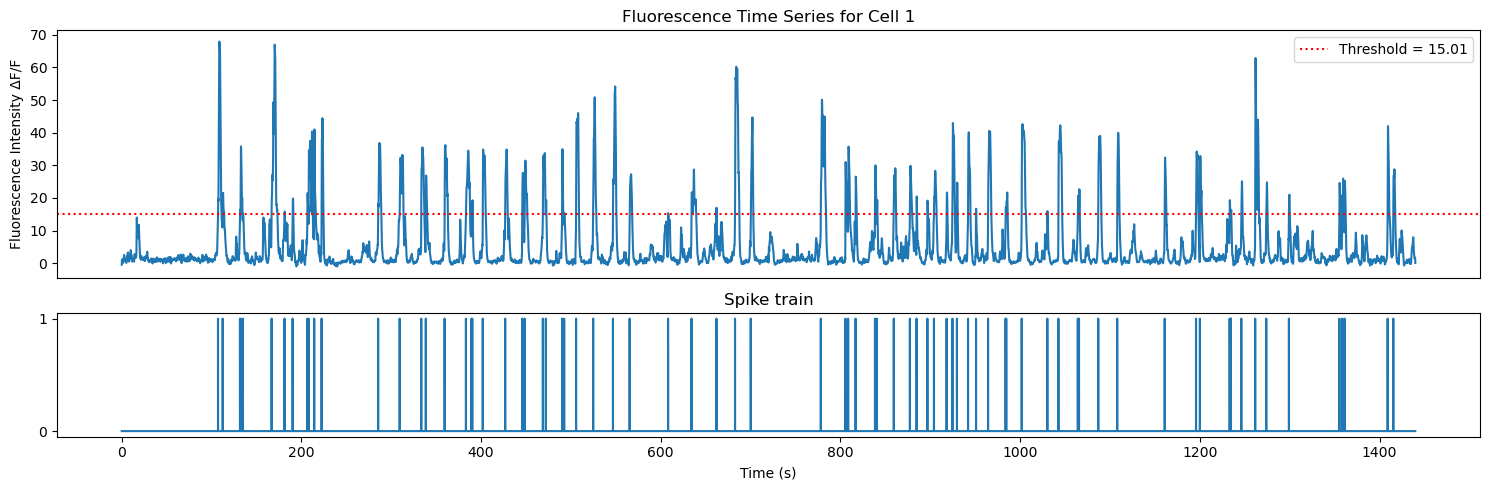

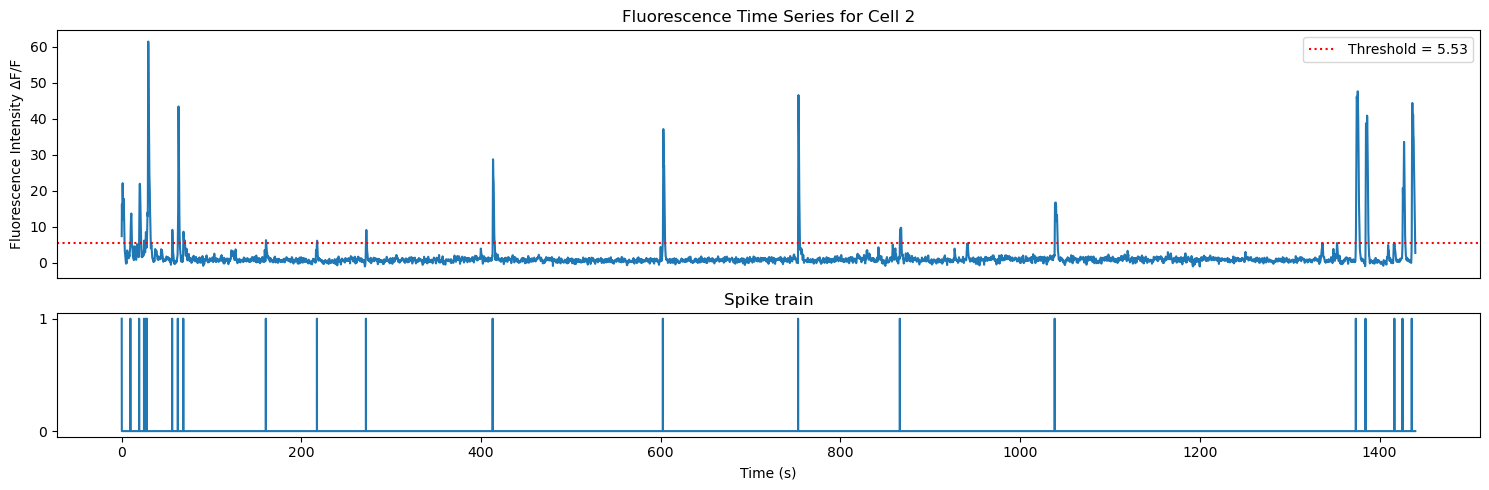

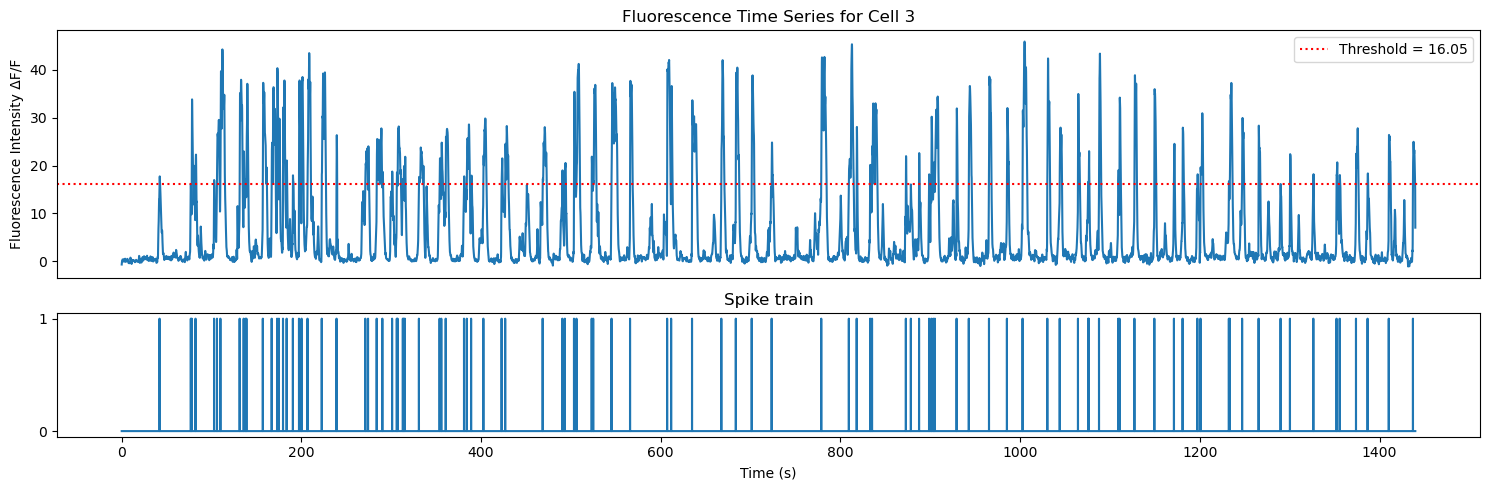

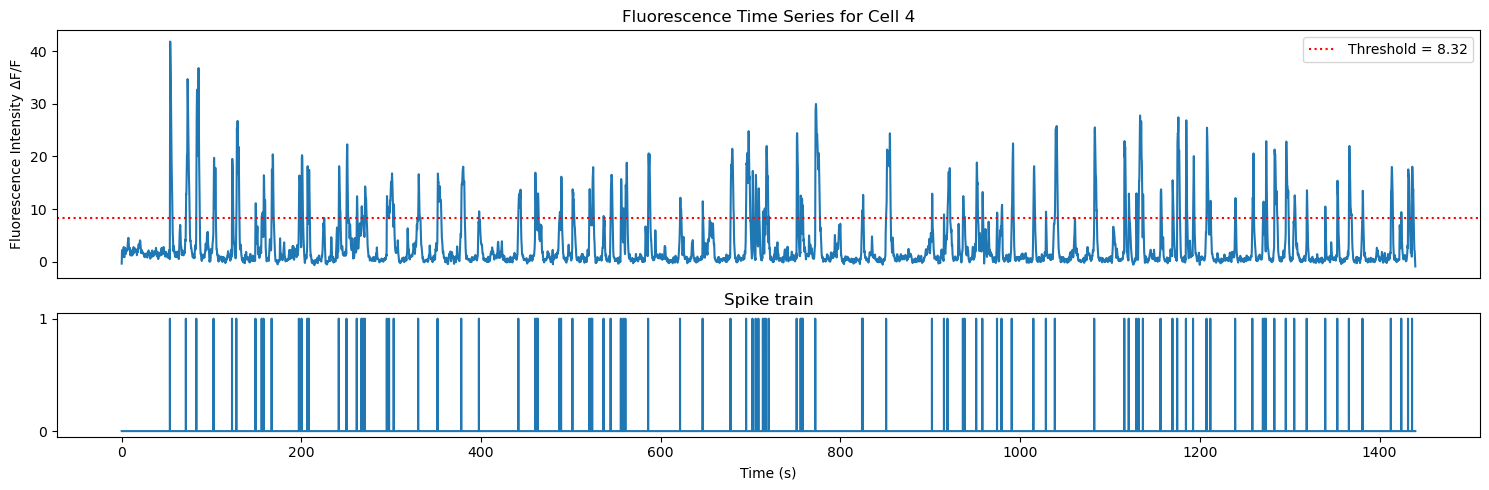

In [ ]:
def detect_events(cell_DF):
    threshold_ = np.mean(cell_DF) + np.std(cell_DF)
    current_peak = False
    events = np.zeros_like(cell_DF)
    for i in range(np.size(cell_DF)):
        trace = cell_DF[i]
        if trace > threshold_ :
            if current_peak == False :
                events[i] = 1
                current_peak = True
        else:
            current_peak = False

    return events, threshold_

cells_spiketrain = []

for i in range(5):
    event_train, threshold = detect_events(dFonF[i])
    cells_spiketrain.append(event_train)
    fig, axes = plt.subplots(2,1, figsize=(15, 5), gridspec_kw={'height_ratios': [2, 1]})
    axes[0].plot(dFonF[i])
    axes[0].set_title(f'Fluorescence Time Series for Cell {i}')
    axes[0].set_ylabel('Fluorescence Intensity ΔF/F')
    axes[0].set_xticks([])
    axes[0].axhline(y=threshold, color='red', linestyle='dotted', label=f'Threshold = {threshold:.2f}')
    axes[0].legend()
    axes[1].plot(t, event_train, label='1:event, 0: no event')
    axes[1].set_title('Spike train')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_yticks([0, 1])

    plt.tight_layout()
    plt.show()

The threshold-crossing method seems quite accurate to represent the spike train, even if it could include some bias in the signal detection by taking into account noise spikes (especially peaks whose amplitude is slightly above the threshold value, but quite low compared to the largest peaks).

We can see that the firing response of the cells are different, if we consider the number of spikes emitted during the duration of the trial, the firing frequency and the amplitude of the peaks.  
- Cell 2 has a low spikes count in comparaison with the other cells.
- The number of spike for cell 0 increase after half of the trial duration (approximately 650 sec), while the firing rate for cell 3 or 4 seem quite constant during the entire experiment.
- Cell 1 and 3 have a higher threshold value (ΔF1/F1=15.01 and ΔF3/F3 = 16.05), meaning a strongest response to stimuli, in comparaison with cells 2 and 4 (ΔF2/F2 = 5.53 and ΔF4/F4 = 8.32).

# Question 2 : Rastergrams

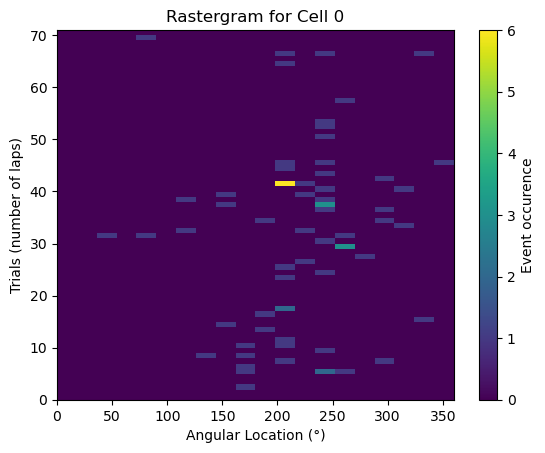

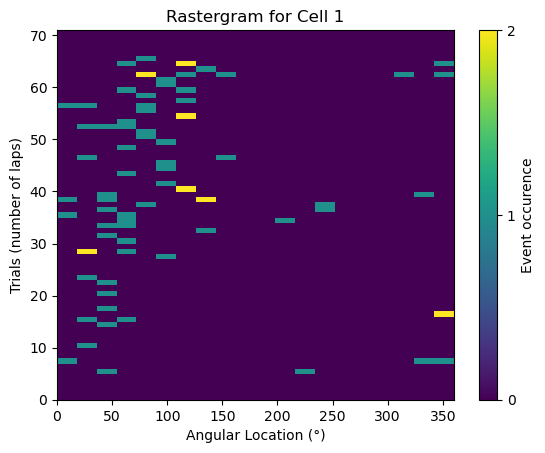

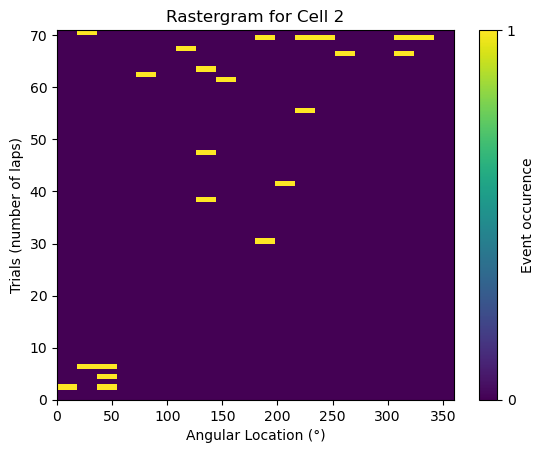

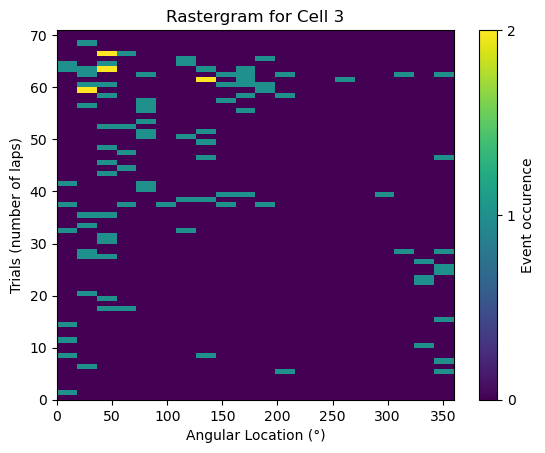

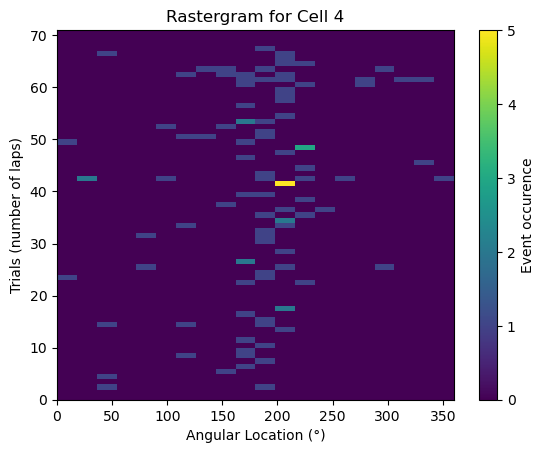

In [ ]:
def get_lapresponse(sp, phi_bin_, nlaps_, nphi_):
    r = np.zeros((nlaps_,nphi_))
    lap=0
    phi0=phi_bin_[0]
    lapflag=True  # flag to ensure we only increment lap counter on first time in bin
    for i in range(0,L):
        if  sp[i]:
            r[lap][phi_bin_[i]-1] += 1
        # and augment lap counter
        if (phi_bin_[i]==phi0 and lapflag==True):
            lap += 1
            lapflag=False # put down flag until we are past this bin
        if phi_bin_[i]>phi0:
            lapflag=True

    return r

#Bin the spatial variable phi
nbins_phi = 20
edges = np.arange(0,360,360/nbins_phi)
phi_bin = np.digitize(phi,edges)

#Number of laps done by the mouse
#Use big jumps in position to mark clocking around circular path
dphi = np.diff(phi_bin,axis=0)
nlaps = np.count_nonzero(dphi>10)+2 # a bit of a hack, sorry - but this works

for i in range(5):
    event_train = cells_spiketrain[i]
    rastergram = get_lapresponse(event_train, phi_bin, nlaps, nbins_phi)
    # Plot the rastergram
    plt.imshow(rastergram, aspect='auto', cmap = 'viridis', extent=[0, 360, 0, nlaps])
    cbar = plt.colorbar(ticks=range(7))
    cbar.set_label('Event occurence')
    plt.xlabel('Angular Location (°)')
    plt.ylabel('Trials (number of laps)')
    plt.title(f'Rastergram for Cell {i}')
    plt.show()

Looking at the rastergrams, we can see that the overall event occurrence for each cell varies between 1 and 2. Only cell 0 and 4 present a tick with a high event occurence, respectively 6 and 5.
- Cell 0: This cell appears to fire more at middle angular positions (between 200° and 250°) in some trials, especially during the 42th lap. This suggests that it might be selective for this spatial location. However, there are still ticks representing a response for a stimuli at various location across the rastergram.
- Cell 1: This cell fires at various locations across trials, but the strip of ticks (i.e events occurence) between 0 and 120° suggests a form of selectivity for range of angles. During the first trials, the cell respond more to angular position between 25 and 50°, and for the latest trials (after 30) they respond more for angle between 75° and 120°, approximately.
- Cell 2: This cell doesn't seem to have any selectivity to a spatial location, as the number of yellow ticks representing the number of spikes is low, and because they spread randomly across the graph. However, the number of yellow seems to increase a little with the number of trials (between 60 and 70).
- Cell 3: Also similar to the rastergram of cell 2, it shows that the event occurence increase with the number of trials. The higher firing rates (yellow ticks) occur from spatial angular location around 15°, 50° and 130°. However, I would say that the selectivity is not very strong as the ticks are quite dispersed on the graphs.
- Cell 4 : The rastergram of cell 4 is quite similar to cell 1, with a large event occurence for 200°, and most of the ticks contain between 150 and 200°, making kind of a "strip".  

We could conclude that the selectivity for a specific angular position should be higher from cell 0 and 4 and not very strong for cell 2. However, I find the average of event occurence quite low to make a strong assumption only taking into account the rastergrams.

# Question 3 : Mutual information

To calculate the mutual information between the spatial location and the response of the cell, I use the function provided by the library sklearn.metrics.
To be noted : this method calculate the muutual information using a logaritm on base e and not a logarithm on base 2 like the Shannon formula.

In [ ]:
from sklearn.metrics import mutual_info_score

for i in range(5):
    event_train = cells_spiketrain[i]
    mutual_information = mutual_info_score(event_train.flatten(), phi_bin.flatten())
    MI = mutual_information
    print(f'The mutual information for cell {i} is equal to {MI:6f}')

The mutual information for cell 0 is equal to 0.000896
The mutual information for cell 1 is equal to 0.001045
The mutual information for cell 2 is equal to 0.000209
The mutual information for cell 3 is equal to 0.000889
The mutual information for cell 4 is equal to 0.001349


Cell 1 and cell 4 have the highest mutual information (respectively 0.001045 and 0.001349), indicating a relatively stronger association between the angular position and the event train for this cell.
Cell 2 has the lowest mutual information (0.000209), suggesting a weaker association compared to the other cells.
Cell 0 and 3 have moderate similar values, around 0.00089.
These results do correspond to the assumption made based on the previous plots.

# Question 4 : Bias

The mutual information calculated can be subject to bias, especially if calculated from finite samples. The bias could come from :
- The discretization of the samples for the spatial angles (number of bins = 20). The more we increase the number of bins, the less will be the bias
- The estimation of probabilities

To estimate the bias, I used the Panzeri-Treves method described in the lectures. The lenght of the data is L = 44520.
To approximate Rtot, the total number of response categories, I used the "naïve approach" of Panzeri-Treves. Rs is approximate by the number of responses that were observed at least once.
N is the number of samples = L, and S the number of bins used in the estimation = nbins_phi, and Rtot is the number of bins in the joint response distribution.  

See References for the method

In [ ]:
event_train = cells_spiketrain[0]
Rtot = len(np.unique(np.column_stack((event_train.flatten(), phi_bin))))

# Calculate Panzeri-Treves Bias
bias = (1 / (2 * L * np.log(2))) * (nbins_phi - 1) * (Rtot - 1)
print(f'The bias value for the mutual information is equal to {bias:6f}.')

The bias value for the mutual information is equal to 0.006157.


# Question 5: Spatial information rates

# 5.a Histogram

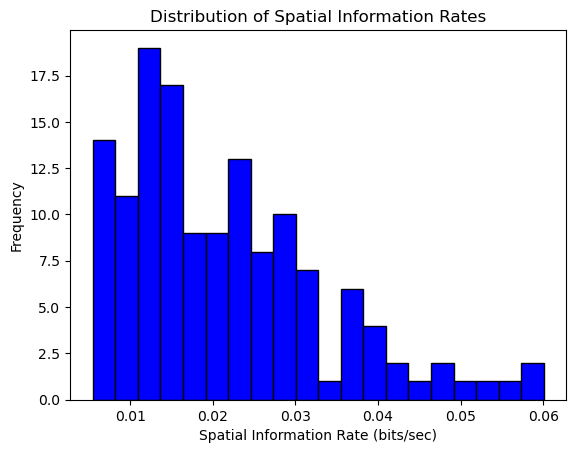

In [ ]:
MI_allcells = []
bin_width_sec = 1/fs

#Calculate the spatial information rate
information_rates = []
for i in range(C):
    event_train, threshold = detect_events(dFonF[i])
    MI = mutual_info_score(event_train.flatten(), phi_bin.flatten())
    MI_allcells.append(MI)
    information_rate = MI / bin_width_sec
    information_rates.append(information_rate)

# Distribution of spatial information rates
plt.hist(information_rates, bins=20, color='blue', edgecolor='black')
plt.xlabel('Spatial Information Rate (bits/sec)')
plt.ylabel('Frequency')
plt.title('Distribution of Spatial Information Rates')
plt.show()

The histogram is left-skewed, with a long tail to the right. This means that there are more spatial information rates at the lower end of the range than at the higher end. The median spatial information rate is about 0.015 bits per second.

This left-skewed distribution shows that the histogram is biased towards places with low spatial information rates.

# 5.b Rastergram of the cell with the highest spatial mutual information

In [ ]:
# Find the cell with the highest spatial mutual information
max_MI_index = np.argmax(MI_allcells)
MI_max = np.max(MI_allcells)
print(f'The cell with the highest spatial mutual information is cell {max_MI_index} with MI = {MI_max:6f}')

The cell with the highest spatial mutual information is cell 77 with MI = 0.001942


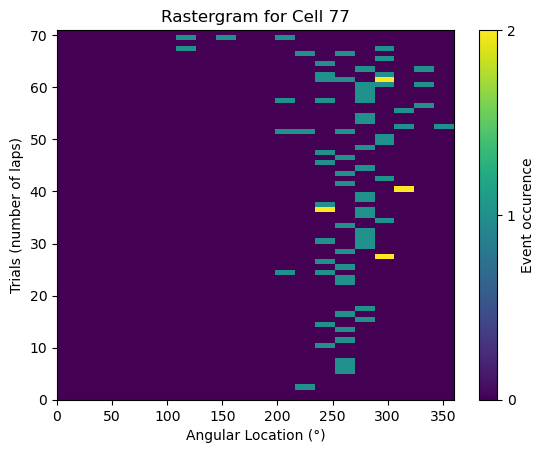

In [ ]:
#Plot the rastergram
event_train, threshold = detect_events(dFonF[max_MI_index])
rastergram = get_lapresponse(event_train, phi_bin, nlaps, nbins_phi)
plt.imshow(rastergram, aspect='auto', cmap = 'viridis', extent=[0, 360, 0, nlaps])
cbar = plt.colorbar(ticks=range(7))
cbar.set_label('Event occurence')
plt.xlabel('Angular Location (°)')
plt.ylabel('Trials (number of laps)')
plt.title(f'Rastergram for Cell {max_MI_index}')
plt.show()

This rastergram shows a better selectivity for angular location between approximately 240° and 260°, especially for the first 30th trials. The ticks do spread out a little further in the latest trials, but still indicating a selectivity for high angular location. The absolute absence of event for angular location below 200°, excluding the last 10 trials, supports the assumption.

The fact that the cell is more selective for a specific location will increase the joint probabilty P(r|s), and thus the value of the mutual information, as well as the spatial information rate. The rastergram shows also less noise activity or lower variability of event occurence.

# References

- A practical guide to information analysis of spike-trains, Gianni Pola, Simon R. Schultz, Rasmus S. Petersen and Stefano Panzeri, 2003